In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../../src")
import feature.scrna_dataset as scrna_dataset
import model.sdes as sdes
import model.generate as generate
import model.scrna_ae as scrna_ae
import model.util as model_util
import analysis.fid as fid
import torch
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import os
import h5py
import json

In [2]:
# Plotting defaults
font_list = font_manager.findSystemFonts(fontpaths=["/gstore/home/tsenga5/modules/fonts"])
for font in font_list:
    font_manager.fontManager.addfont(font)
plot_params = {
    "figure.titlesize": 22,
    "axes.titlesize": 22,
    "axes.labelsize": 20,
    "legend.fontsize": 18,
    "font.size": 13,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "font.family": "Roboto",
    "font.weight": "bold",
    "svg.fonttype": "none"
}
plt.rcParams.update(plot_params)

In [3]:
# Define device
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

### Define constants and paths

In [4]:
models_base_path = "/gstore/data/resbioai/tsenga5/branched_diffusion/models/trained_models/"

# branched_model_path = os.path.join(models_base_path, "scrna_covid_flu_continuous_branched_9classes_latent_d200/3/last_ckpt.pth")
branched_model_path = os.path.join(models_base_path, "scrna_covid_flu_continuous_branched_9classes_latent_d100/2/last_ckpt.pth")

In [5]:
def import_classes_branch_points(json_path):
    with open(json_path, "r") as f:
        d = json.load(f)
        return d["classes"], \
            [(tuple(trip[0]), trip[1], trip[2]) for trip in d["branches"]]
    
classes, branch_defs = import_classes_branch_points(
    "/gstore/home/tsenga5/branched_diffusion/data/config/classes_branch_points/scrna_covid_flu/redset.json"
)

In [6]:
latent_space = True
latent_dim = 100

In [7]:
data_file = "/gstore/data/resbioai/tsenga5/branched_diffusion/data/scrna/covid_flu/processed/covid_flu_processed_reduced_genes.h5"
autoencoder_path = "/gstore/data/resbioai/tsenga5/branched_diffusion/models/trained_models/scrna_vaes/covid_flu/covid_flu_processed_reduced_genes_ldvae_d%d/" % latent_dim

cell_data_file = "/gstore/home/tsenga5/branched_diffusion/data/scrna/covid_flu/cell_data.csv"

In [8]:
# Import gene names and marker genes
with h5py.File(data_file, "r") as f:
    gene_names = f["gene_names"][:].astype(str)
    marker_genes = {}
    for class_i in classes:
        marker_genes[class_i] = f["marker_genes"][str(class_i)][:].astype(str)
    
genes_of_interest = np.array(["NFKB1", "NFKB2", "IRF1", "CXCR3", "CXCL10", "STAT1", "TLR4", "TGFB1", "IL1B", "IFNG", "TLR4", "TNFSF4", "IL1R2", "IL1B", "IL7R", "IL32"])

In [9]:
out_path = "/gstore/home/tsenga5/branched_diffusion/figures/scrna_covid_flu_hybrid_transmutation"

os.makedirs(out_path, exist_ok=True)

### Create data loader

In [10]:
dataset = scrna_dataset.SingleCellDataset(data_file, autoencoder_path=(autoencoder_path if latent_space else None))

with h5py.File(dataset.scrna_h5_path, "r") as f:
    cell_ids = f["cell_id"][:].astype(str)

# Limit classes
inds = np.isin(dataset.cell_cluster, classes)
dataset.data = dataset.data[inds]
dataset.cell_cluster = dataset.cell_cluster[inds]
cell_ids = cell_ids[inds]

data_loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True, num_workers=0)
input_shape = next(iter(data_loader))[0].shape[1:]

[rank: 0] Global seed set to 0


INFO     File                                                                                                      
         /gstore/data/resbioai/tsenga5/branched_diffusion/models/trained_models/scrna_vaes/covid_flu/covid_flu_proc
         essed_reduced_genes_ldvae_d100/model.pt already downloaded                                                


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
/gstore/home/tsenga5/miniconda3/envs/scanpy/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:91: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(


In [11]:
sde = sdes.VariancePreservingSDE(0.1, 5, input_shape)
t_limit = 1

In [12]:
# TODO: this is currently rather inefficient; a decision-tree-style structure
# would be better

def class_time_to_branch(c, t):
    """
    Given a class and a time (both scalars), return the
    corresponding branch index.
    """
    for i, branch_def in enumerate(branch_defs):
        if c in branch_def[0] and t >= branch_def[1] and t <= branch_def[2]:
            return i
    raise ValueError("Undefined class and time")
        
def class_time_to_branch_tensor(c, t):
    """
    Given tensors of classes and a times, return the
    corresponding branch indices as a tensor.
    """
    return torch.tensor([
        class_time_to_branch(c_i, t_i) for c_i, t_i in zip(c, t)
    ], device=DEVICE)

### Import the model

In [13]:
model = model_util.load_model(
    scrna_ae.MultitaskResNet, branched_model_path
).to(DEVICE)

In [14]:
# Sample objects from the original dataset
true_samples = {}
if latent_space:
    true_latent_samples = {}
for class_to_sample in classes:
    print("Sampling class: %s" % class_to_sample)
    inds = np.where(dataset.cell_cluster == class_to_sample)[0]
    sample_inds = np.random.choice(inds, size=min(64, len(inds)), replace=False)
    sample = dataset.data[sample_inds]
    if latent_space:
        true_latent_samples[class_to_sample] = dataset.encode_batch(torch.tensor(sample, device=DEVICE)).cpu().numpy()
        # For samples in expression space (not latent space), decode anyways for a more comparable distribution
        true_samples[class_to_sample] = dataset.decode_batch(torch.tensor(true_latent_samples[class_to_sample], device=DEVICE)).cpu().numpy()
    else:
        true_samples[class_to_sample] = sample

Sampling class: 0
Sampling class: 1
Sampling class: 2
Sampling class: 3
Sampling class: 4
Sampling class: 5
Sampling class: 7
Sampling class: 10
Sampling class: 12


In [15]:
# Rescale sampled values to match range of true values based on standard deviation
def rescale_samples(samps, samp_class):
    t = true_samples[samp_class]

    s_z = (samps - np.mean(samps, axis=0, keepdims=True)) / np.std(samps, axis=0, keepdims=True)
    s_trans = (s_z * np.std(t, axis=0, keepdims=True)) + np.mean(t, axis=0, keepdims=True)
    
    return np.nan_to_num(s_trans)  # Convert NaNs to 0s

### Transmutation

In [16]:
torch.manual_seed(20230320)

In [17]:
class_1, class_2 = 0, 1
branch_time = branch_defs[min(
    range(len(branch_defs)),
    key=(lambda i: branch_defs[i][1] if (
        class_1 in branch_defs[i][0] and class_2 in branch_defs[i][0]
    ) else float("inf"))
)][1]

orig_1 = torch.stack([
    dataset[i][0].to(DEVICE) for i in 
    np.random.choice(np.where(dataset.cell_cluster == class_1)[0], size=200, replace=False)
])
orig_2 = torch.stack([
    dataset[i][0].to(DEVICE) for i in 
    np.random.choice(np.where(dataset.cell_cluster == class_2)[0], size=200, replace=False)
])

time_steps = 10
all_t = np.linspace(0, branch_time, time_steps)
forward_1_to_2 = torch.empty((len(all_t),) + orig_1.shape, device=DEVICE)
backward_1_to_2 = torch.empty((len(all_t) - 1,) + orig_1.shape, device=DEVICE)
forward_2_to_1 = torch.empty((len(all_t),) + orig_2.shape, device=DEVICE)
backward_2_to_1 = torch.empty((len(all_t) - 1,) + orig_2.shape, device=DEVICE)
for t_i, t in enumerate(all_t):
    forward_1_to_2[t_i] = sde.forward(
        orig_1, torch.ones(len(orig_1)).to(DEVICE) * t
    )[0]
    forward_2_to_1[t_i] = sde.forward(
        orig_2, torch.ones(len(orig_2)).to(DEVICE) * t
    )[0]

all_t_flip = np.flip(all_t)
last_1_to_2 = torch.tensor(forward_1_to_2[-1]).to(DEVICE).float()
last_2_to_1 = torch.tensor(forward_2_to_1[-1]).to(DEVICE).float()
for t_i in range(len(all_t_flip) - 1):
    last_1_to_2 = generate.generate_continuous_branched_samples(
        model, sde, class_2, class_time_to_branch_tensor, sampler="pc",
        t_limit=all_t_flip[t_i], t_start=all_t_flip[t_i + 1],
        num_samples=orig_1.shape[0], initial_samples=last_1_to_2,
        num_steps=50
    )
    backward_1_to_2[t_i] = last_1_to_2

    last_2_to_1 = generate.generate_continuous_branched_samples(
        model, sde, class_1, class_time_to_branch_tensor, sampler="pc",
        t_limit=all_t_flip[t_i], t_start=all_t_flip[t_i + 1],
        num_samples=orig_2.shape[0], initial_samples=last_2_to_1,
        num_steps=50
    )
    backward_2_to_1[t_i] = last_2_to_1

before_1_to_2, after_1_to_2 = forward_1_to_2[0], backward_1_to_2[-1]
before_2_to_1, after_2_to_1 = forward_2_to_1[0], backward_2_to_1[-1]

# Decode all
if latent_space:
    orig_1, orig_2 = dataset.decode_batch(orig_1).cpu().numpy(), dataset.decode_batch(orig_2).cpu().numpy()
    before_1_to_2, after_1_to_2 = dataset.decode_batch(before_1_to_2).cpu().numpy(), dataset.decode_batch(after_1_to_2).cpu().numpy()
    before_2_to_1, after_2_to_1 = dataset.decode_batch(before_2_to_1).cpu().numpy(), dataset.decode_batch(after_2_to_1).cpu().numpy()

/local/681151/ipykernel_24311/2120700869.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  last_1_to_2 = torch.tensor(forward_1_to_2[-1]).to(DEVICE).float()
/local/681151/ipykernel_24311/2120700869.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  last_2_to_1 = torch.tensor(forward_2_to_1[-1]).to(DEVICE).float()


In [18]:
# Rescale sampled values to match range of true values based on standard deviation
after_1_to_2_scaled = rescale_samples(after_1_to_2, class_2)
after_2_to_1_scaled = rescale_samples(after_2_to_1, class_1)

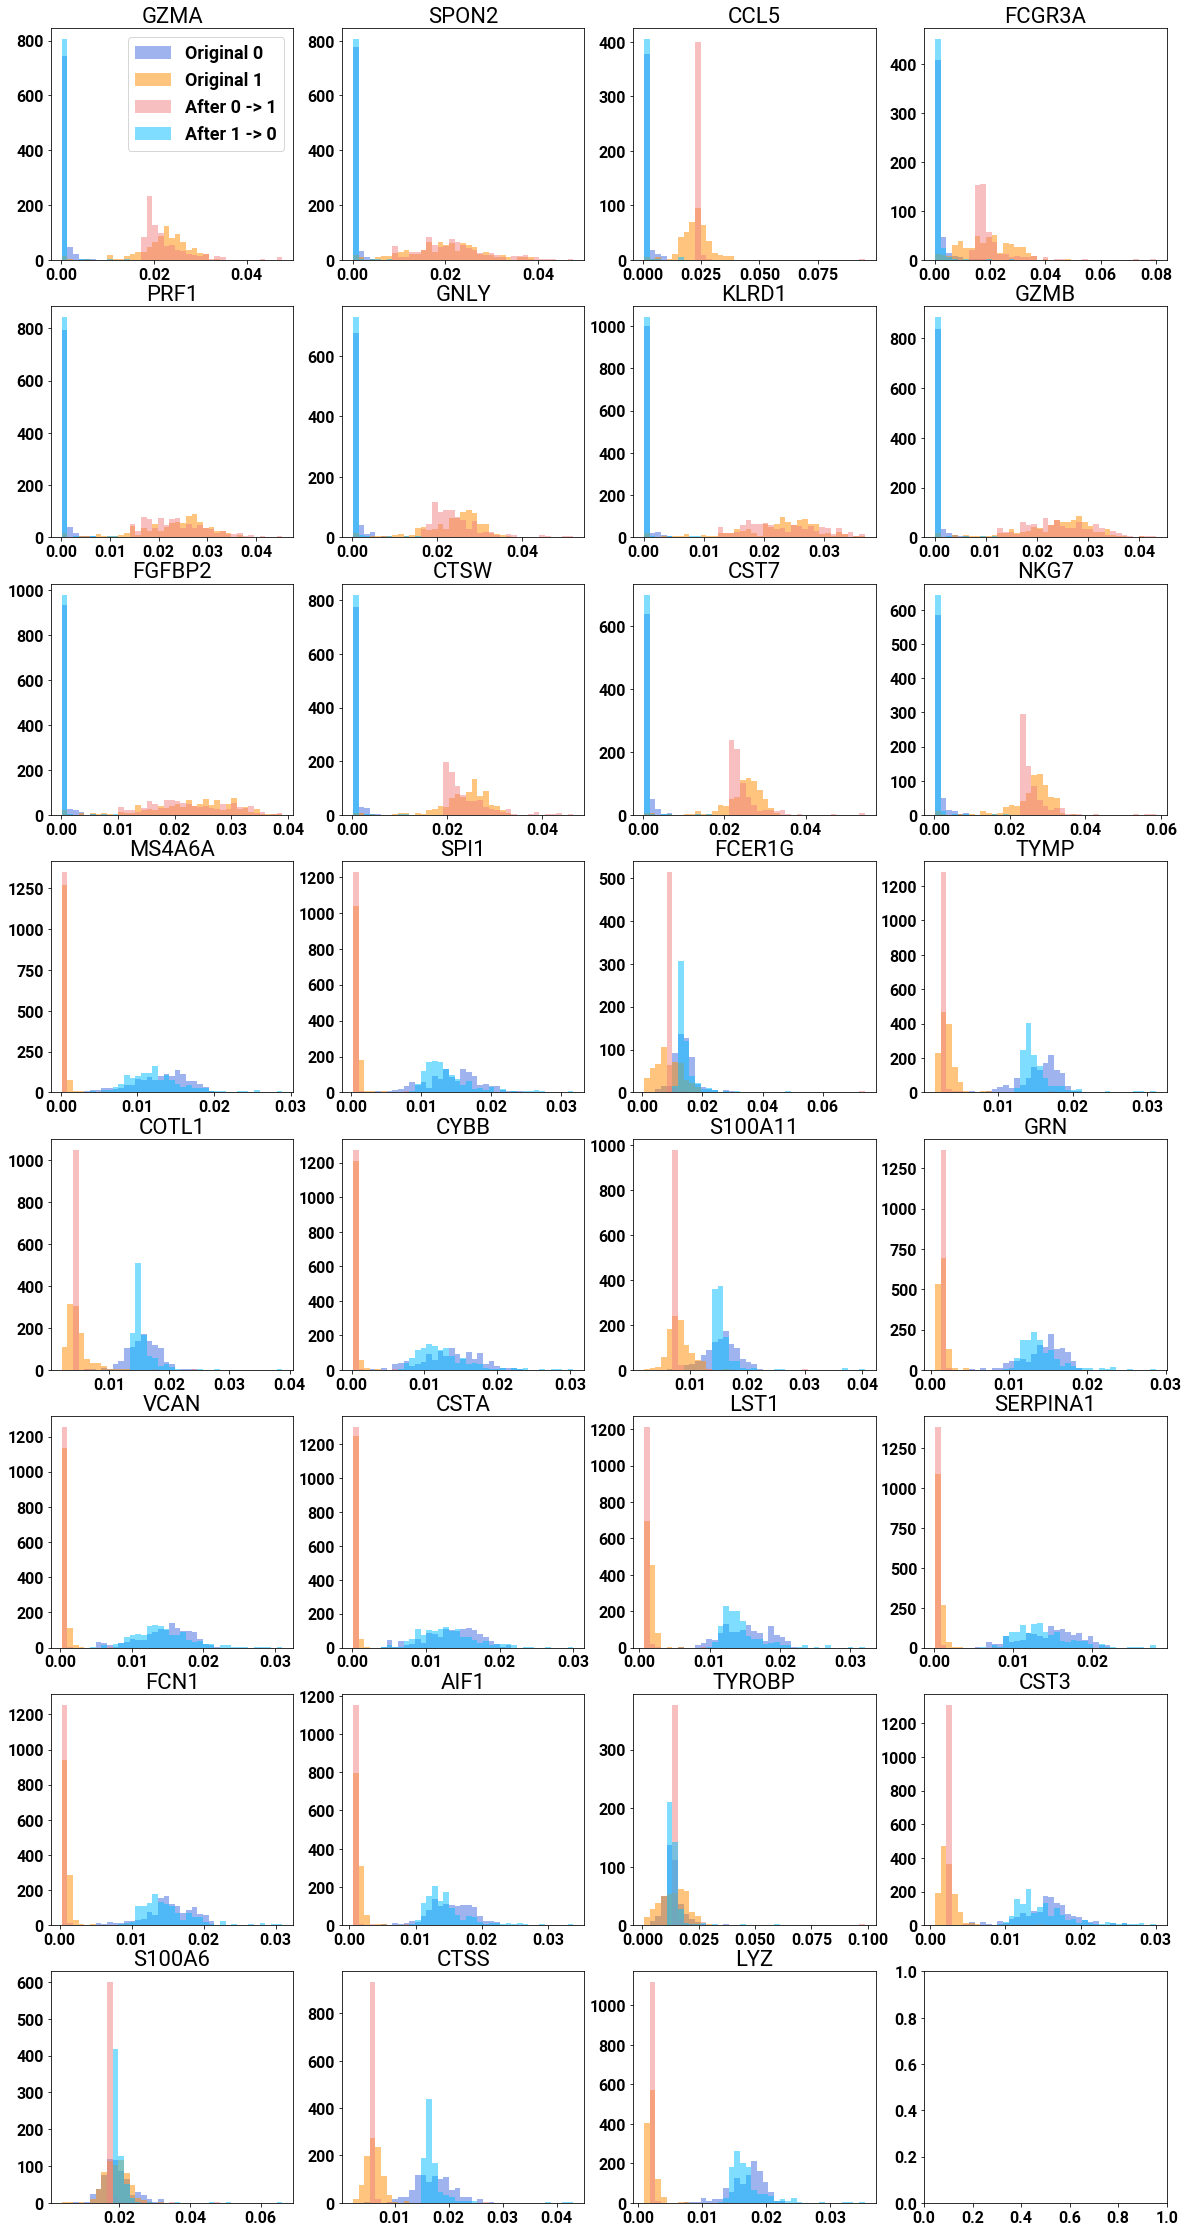

In [19]:
# Plot marker genes
feature_inds = []
for gene in np.concatenate([marker_genes[class_1], marker_genes[class_2]]):
    if gene in gene_names:
        feature_inds.append(np.where(gene_names == gene)[0][0])
num_to_plot = len(feature_inds)

num_cols = 4
num_rows = int(np.ceil(num_to_plot / num_cols))
num_bins = 40

# Plot feature values
fig, ax = plt.subplots(ncols=num_cols, nrows=num_rows, figsize=(num_cols * 5, num_rows * 5))
for i, f_i in enumerate(feature_inds):
    r, c = i // num_cols, i % num_cols
    orig_1_vals, orig_2_vals = orig_1[:, f_i], orig_2[:, f_i]
    after_1_to_2_vals, after_2_to_1_vals = after_1_to_2_scaled[:, f_i], after_2_to_1_scaled[:, f_i]

    all_vals = np.concatenate([orig_1_vals, orig_2_vals, after_1_to_2_vals, after_2_to_1_vals])
    bins = np.linspace(
        max(0, np.min(all_vals)), min(np.max(all_vals), 20), num_bins
    )
    ax[r][c].hist(orig_1_vals, bins=bins, color="royalblue", label=("Original %d" % class_1), density=True, alpha=0.5)
    ax[r][c].hist(orig_2_vals, bins=bins, color="darkorange", label=("Original %d" % class_2), density=True, alpha=0.5)
    ax[r][c].hist(after_1_to_2_vals, bins=bins, color="lightcoral", label=("After %d -> %d" % (class_1, class_2)), density=True, alpha=0.5)
    ax[r][c].hist(after_2_to_1_vals, bins=bins, color="deepskyblue", label=("After %d -> %d" % (class_2, class_1)), density=True, alpha=0.5)
    ax[r][c].set_title(gene_names[f_i])
ax[0][0].legend()
fig.savefig(
    os.path.join(out_path, "transmutation_predictions_marker_genes.svg"),
    format="svg"
)
plt.show()

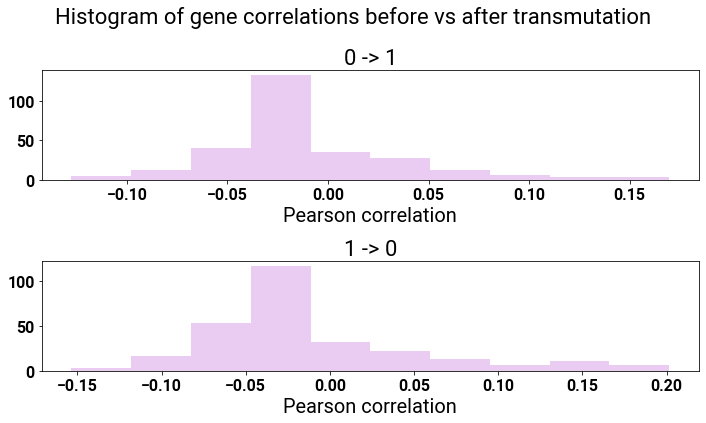

In [20]:
# Compute correlation of features before and after transmutation
num_features = before_1_to_2.shape[1]
corrs_1_to_2, corrs_2_to_1 = np.empty(num_features), np.empty(num_features)
for i in range(num_features):
    corrs_1_to_2[i] = scipy.stats.pearsonr(
        before_1_to_2[:, i], after_1_to_2_scaled[:, i]
    )[0]
    corrs_2_to_1[i] = scipy.stats.pearsonr(
        before_2_to_1[:, i], after_2_to_1_scaled[:, i]
    )[0]

fig, ax = plt.subplots(nrows=2, figsize=(10, 6))
ax[0].hist(corrs_1_to_2, bins=10, color="mediumorchid", alpha=0.3)
ax[1].hist(corrs_2_to_1, bins=10, color="mediumorchid", alpha=0.3)
ax[0].set_title("%d -> %d" % (class_1, class_2))
ax[1].set_title("%d -> %d" % (class_2, class_1))
for i in range(2):
    ax[i].set_xlabel("Pearson correlation")
fig.suptitle("Histogram of gene correlations before vs after transmutation")
fig.tight_layout()
fig.savefig(
    os.path.join(out_path, "transmutation_corr_all_genes.svg"),
    format="svg"
)
plt.show()

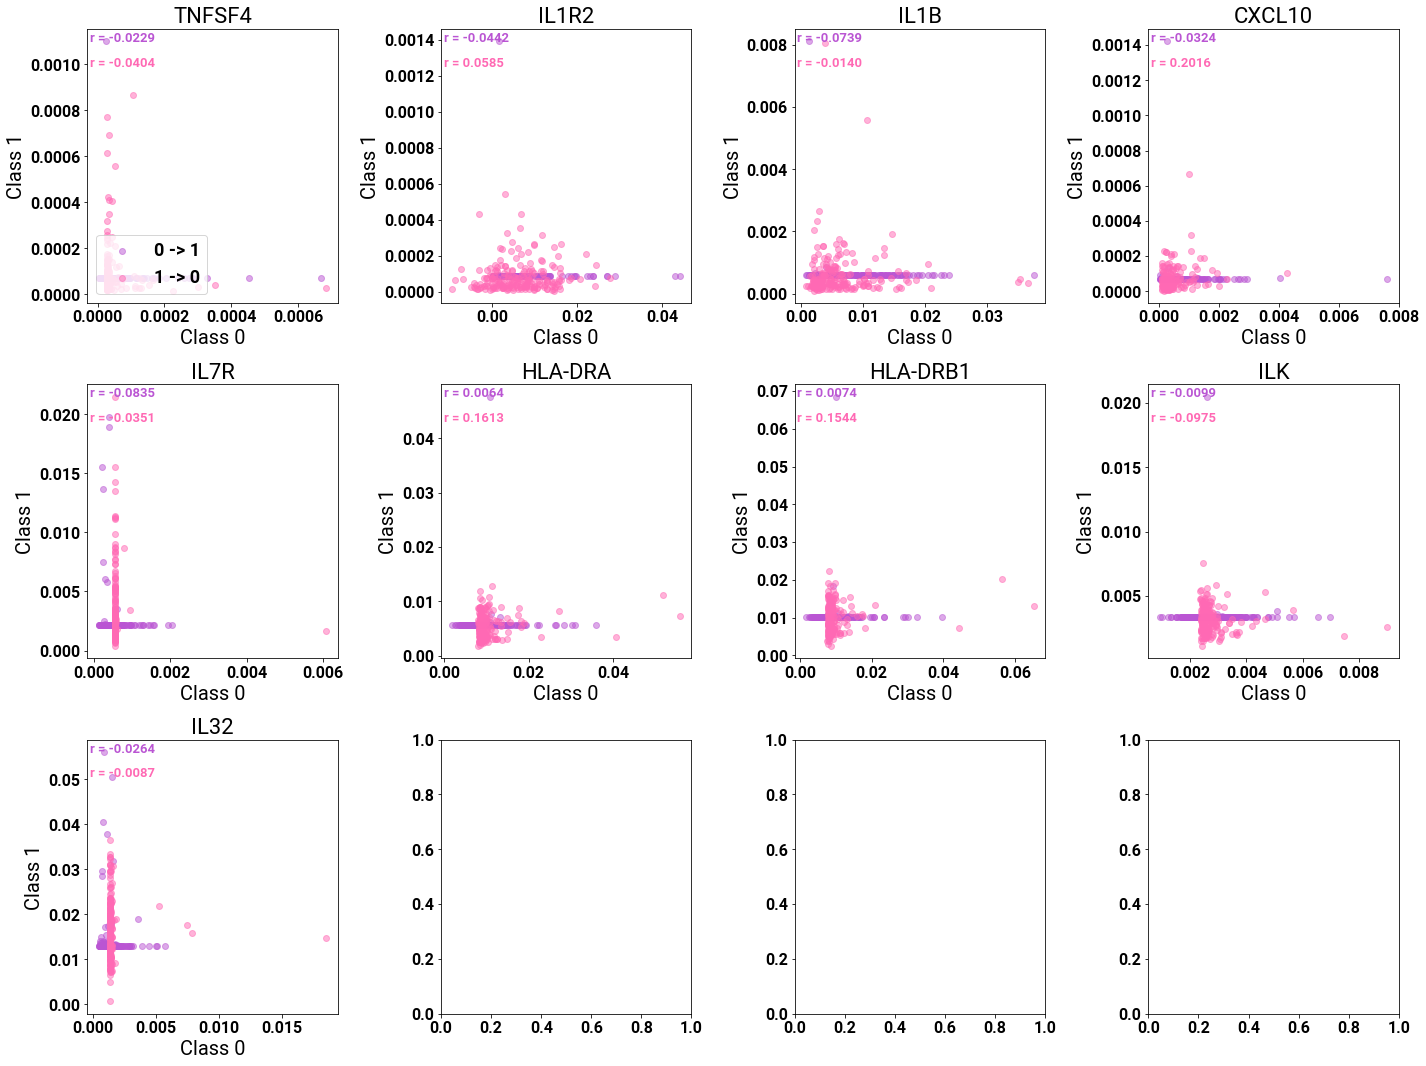

In [21]:
# Plot pre/post-transmutation correlation of genes of interest
gene_match = lambda n: n.startswith("IL") or n.startswith("HLA") or n.startswith("TNF")
feature_inds = [i for i in range(len(gene_names)) if gene_match(gene_names[i])]
feature_inds.extend(
    [np.where(gene_names == gene)[0][0] for gene in genes_of_interest if gene in gene_names]
)
feature_inds = np.unique(feature_inds)
num_to_plot = len(feature_inds)

num_cols = 4
num_rows = int(np.ceil(num_to_plot / num_cols))

# Plot correlations
fig, ax = plt.subplots(ncols=num_cols, nrows=num_rows, figsize=(num_cols * 5, num_rows * 5))
for i, f_i in enumerate(feature_inds):
    r, c = i // num_cols, i % num_cols
    
    before_1_to_2_vals, after_1_to_2_vals = before_1_to_2[:, f_i], after_1_to_2_scaled[:, f_i]
    before_2_to_1_vals, after_2_to_1_vals = before_2_to_1[:, f_i], after_2_to_1_scaled[:, f_i]
    
    ax[r][c].scatter(before_1_to_2_vals, after_1_to_2_vals, alpha=0.5, color="mediumorchid", label=("%d -> %d" % (class_1, class_2)))
    ax[r][c].scatter(after_2_to_1_vals, before_2_to_1_vals, alpha=0.5, color="hotpink", label=("%d -> %d" % (class_2, class_1)))
    ax[r][c].text(
        0.01, 0.99, "r = %.4f" % corrs_1_to_2[f_i],
        ha="left", va="top", transform=ax[r][c].transAxes, color="mediumorchid"
    )
    ax[r][c].text(
        0.01, 0.90, "r = %.4f" % corrs_2_to_1[f_i],
        ha="left", va="top", transform=ax[r][c].transAxes, color="hotpink"
    )
    
    ax[r][c].set_xlabel("Class %d" % class_1)
    ax[r][c].set_ylabel("Class %d" % class_2)
    ax[r][c].set_title(gene_names[f_i])
ax[0][0].legend(loc="lower left")
fig.tight_layout()
fig.savefig(
    os.path.join(out_path, "transmutation_corr_genes_of_interest.svg"),
    format="svg"
)
plt.show()

In [22]:
# Top genes with highest correlations
print("Highest gene correlations: %d -> %d" % (class_1, class_2))
print("\t" + ", ".join(gene_names[np.argsort(corrs_1_to_2)[-20:]]))
print()
print("Highest gene correlations: %d -> %d" % (class_2, class_1))
print("\t" + ", ".join(gene_names[np.argsort(corrs_2_to_1)[-20:]]))

Highest gene correlations: 0 -> 1
	CYBB, TRDC, LYPD2, VSIG4, FOLR3, TYMP, AL034397.3, RAB32, LYL1, LYZ, AC020656.1, RETN, FCN1, FCER1A, CST3, GRN, PTGIR, DAPP1, P2RX1, CD68

Highest gene correlations: 1 -> 0
	FOS, S100A6, NEAT1, MNDA, DUSP2, TCL1A, IGHM, NCF1, HLA-DRB1, MARCKS, MS4A1, CD79A, CTSS, HLA-DRA, CXCR4, CD74, IGHD, JUN, LINC00926, CXCL10


In [23]:
# Import metadata on each cell
cell_data = pd.read_csv(cell_data_file, sep=",", header=0, index_col=False)

# Map each barcode tail to condition
cond_map = {}
conds = [
    "Normal", "Flu", "COVID-19 (Mild)", "COVID-19 (Severe)", "Asymptomatic"
]
for cond in conds:
    tails = np.unique(
        cell_data[cell_data["Disease condition"] == cond]["Barcode sequence"].apply(lambda s: int(s.split("-")[1]))
    )
    for tail in tails:
        assert tail not in cond_map
        cond_map[tail] = cond
        
# Map each cell to its condition
cell_conds = np.array([cond_map[int(cid.split("-")[1])] for cid in cell_ids])

# Create masks for each condition
cond_masks = {cond : cell_conds == cond for cond in conds}

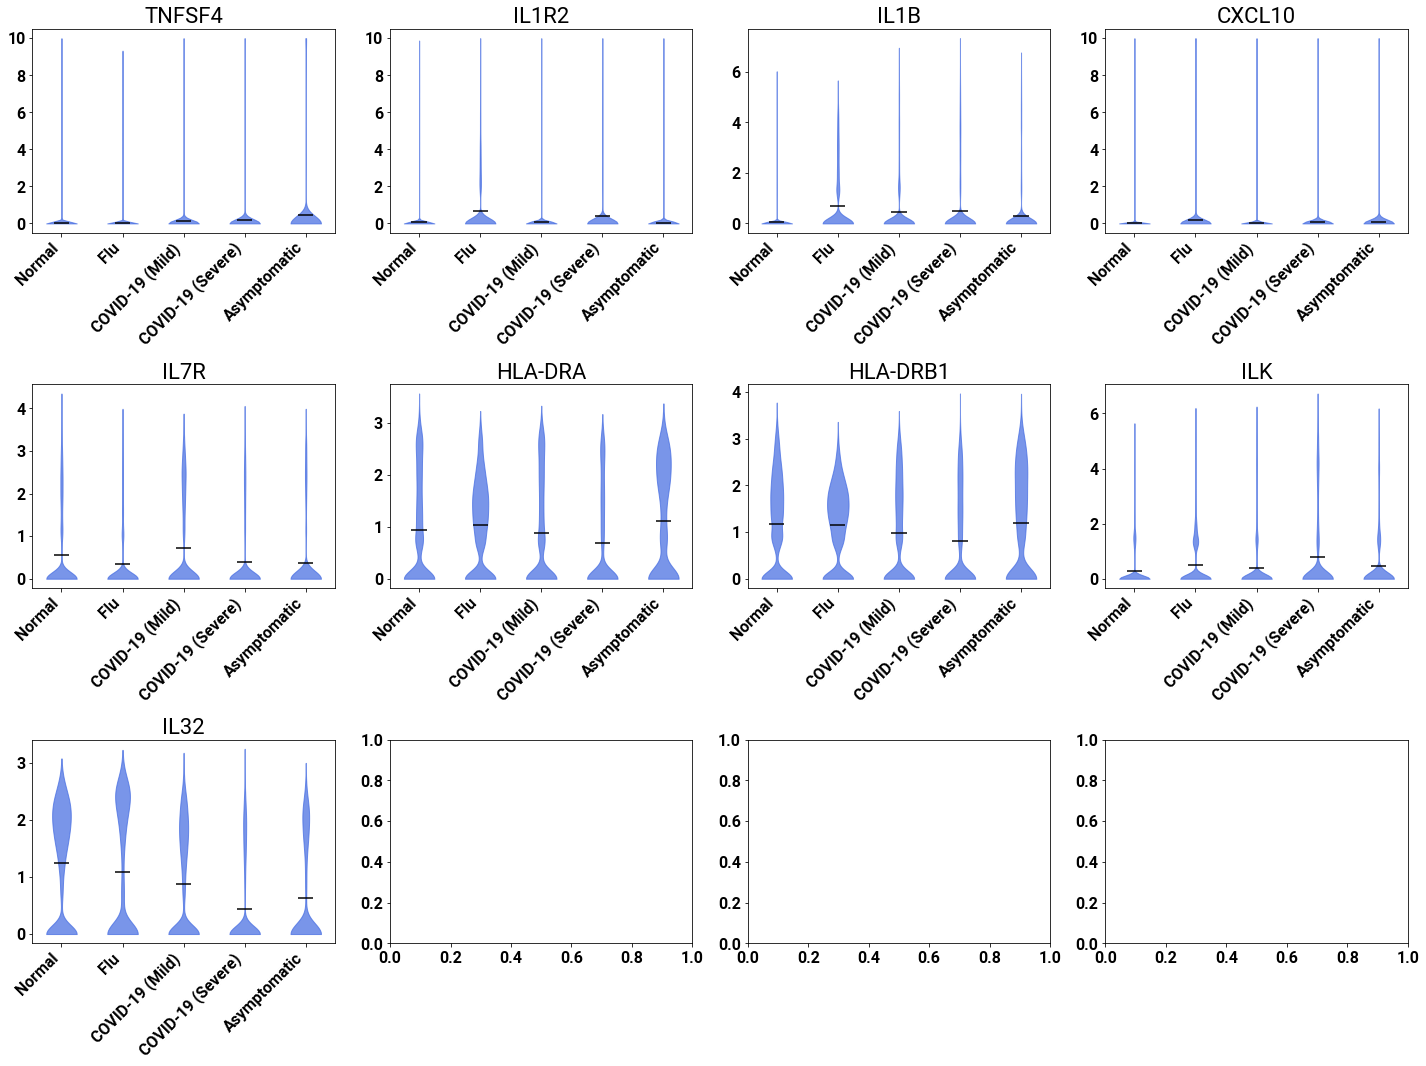

In [24]:
# Plot distribution of expression of genes of interest by condition
num_to_plot = len(feature_inds)

num_cols = 4
num_rows = int(np.ceil(num_to_plot / num_cols))

# Plot correlations
fig, ax = plt.subplots(ncols=num_cols, nrows=num_rows, figsize=(num_cols * 5, num_rows * 5))
for i, f_i in enumerate(feature_inds):
    r, c = i // num_cols, i % num_cols
    
    exprs = dataset.data[:, f_i]
    data = [exprs[cond_masks[cond]] for cond in conds]
    
    plot_parts = ax[r][c].violinplot(
        data, showmeans=True, showmedians=False, showextrema=False
    )

    for j, _ in enumerate(conds):
        plot_parts["bodies"][j].set_facecolor("royalblue")
        plot_parts["bodies"][j].set_edgecolor("royalblue")
        plot_parts["bodies"][j].set_alpha(0.7)
    plot_parts["cmeans"].set_color("black")
    
    ax[r][c].set_title(gene_names[f_i])
    ax[r][c].set_xticks(np.arange(1, len(data) + 1))
    ax[r][c].set_xticklabels(conds, rotation=45, ha="right")
fig.tight_layout()
fig.savefig(
    os.path.join(out_path, "true_expressions_by_condition.svg"),
    format="svg"
)
plt.show()